In [5]:
!gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ

Downloading...
From (original): https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
From (redirected): https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ&confirm=t&uuid=16da8517-aedb-4c1e-a4eb-d7f2f3493f89
To: /content/lightcast_job_postings.csv
100% 717M/717M [00:05<00:00, 142MB/s]


In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import plotly.express as px

# Start Spark session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load dataset
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .csv("lightcast_job_postings.csv")

df.printSchema()
df.show(5)


root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

In [7]:
# Drop rows with nulls in required columns
cols = ["SALARY", "MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "EMPLOYMENT_TYPE_NAME"]
df_clean = df.select(cols).dropna()

# Encode categorical variable
indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE_NAME", outputCol="EMPLOYMENT_TYPE_INDEX")
df_indexed = indexer.fit(df_clean).transform(df_clean)

encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_INDEX", outputCol="EMPLOYMENT_TYPE_VEC")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Assemble features
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "MODELED_DURATION", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)
final_df = assembler.transform(df_encoded).select("features", "SALARY")
final_df.show(5)


+-------------------+------+
|           features|SALARY|
+-------------------+------+
|[10.0,41.0,1.0,0.0]|107645|
| [6.0,55.0,1.0,0.0]|192800|
|[12.0,18.0,1.0,0.0]|125900|
| [6.0,55.0,1.0,0.0]|170000|
| [5.0,20.0,1.0,0.0]|118560|
+-------------------+------+
only showing top 5 rows



In [9]:
train_data, test_data = final_df.randomSplit([0.82, 0.18], seed=620)
print(f"Train rows: {train_data.count()}, Test rows: {test_data.count()}")

Train rows: 13770, Test rows: 3070


In [22]:
lr = LinearRegression(featuresCol='features', labelCol='SALARY')
lr_model = lr.fit(train_data)

# Predict on test data
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


RMSE: 37508.17
R²: 0.2728


### Model Evaluation

####  R² Score: 0.2728  

The R² value indicates that approximately **27.28% of the variation in salaries** is explained by the model’s features: years of experience, modeled duration, and employment type. While not very high, it's expected given the simplicity of the model and the limited features used.

####  RMSE: $37,508.17  

This means the **average prediction error** is about **$37.5K**, which reflects the natural variance in salary data and the model’s limited predictive power.

---

**Conclusion:**  
The model demonstrates a basic understanding of salary trends using limited features. For improved accuracy and explanatory power, additional features (e.g., skills, company size, location, job title) should be included in future iterations.


In [21]:
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"MAE: {mae:.2f}")


MAE: 29087.63


In [18]:
print("Length of coefficients:", len(lr_model.coefficients))
print("Length of StdError:", len(summary.coefficientStandardErrors))
print("Length of tValues:", len(summary.tValues))
print("Length of pValues:", len(summary.pValues))



Length of coefficients: 4
Length of StdError: 5
Length of tValues: 5
Length of pValues: 5


In [19]:
coefs_df = pd.DataFrame({
    "Term": ["Intercept"] + [f"Feature_{i}" for i in range(len(lr_model.coefficients))],
    "Coefficient": [lr_model.intercept] + list(lr_model.coefficients),
    "StdError": summary.coefficientStandardErrors,
    "tValue": summary.tValues,
    "pValue": summary.pValues
})

coefs_df


,Term,Coefficient,StdError,tValue,pValue
0,Intercept,83446.694198,94.336702,69.247087,0.000000
1,Feature_0,6532.541756,24.025683,2.201706,0.027703
2,Feature_1,52.897485,2283.899198,0.030374,0.975769
3,Feature_2,69.371784,2976.180616,-1.657564,0.097428
4,Feature_3,-4933.208561,2330.596535,35.804865,0.000000


In [32]:
pdf = predictions.select("SALARY", "prediction").toPandas()
pdf["residuals"] = pdf["SALARY"] - pdf["prediction"]

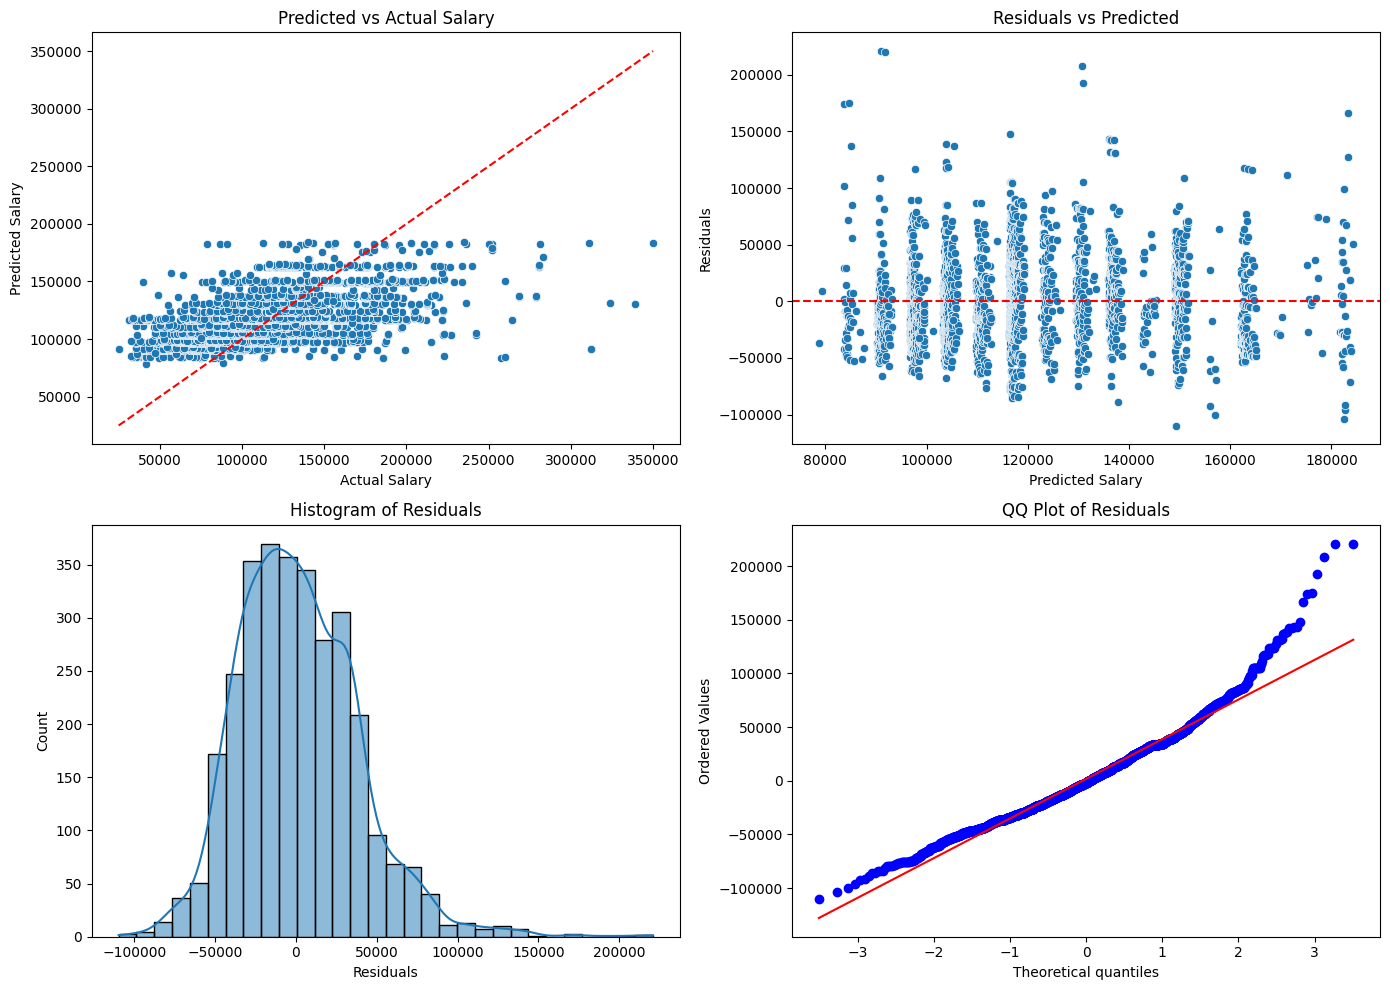

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(14, 10))

# 1. Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x=pdf["SALARY"], y=pdf["prediction"])
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")
plt.plot([pdf["SALARY"].min(), pdf["SALARY"].max()],
         [pdf["SALARY"].min(), pdf["SALARY"].max()],
         color="red", linestyle="--")

# 2. Residuals vs Predicted
plt.subplot(2, 2, 2)
sns.scatterplot(x=pdf["prediction"], y=pdf["residuals"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(pdf["residuals"], bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")

# 4. QQ Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(pdf["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()


In [43]:
#Not Required (doing it genereally)
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats
import pandas as pd

# Ensure you already have this DataFrame ready from previous steps
# pdf = predictions.select("SALARY", "prediction").toPandas()
pdf["residuals"] = pdf["SALARY"] - pdf["prediction"]

# --- Dashboard Layout ---
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Predicted vs Actual",
    "Residuals vs Predicted",
    "Histogram of Residuals",
    "QQ Plot of Residuals"
))

# 1. Predicted vs Actual
fig.add_trace(
    go.Scatter(x=pdf["SALARY"], y=pdf["prediction"], mode='markers', name='Data'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[pdf["SALARY"].min(), pdf["SALARY"].max()],
               y=[pdf["SALARY"].min(), pdf["SALARY"].max()],
               mode='lines', name='Ideal Fit', line=dict(color='red', dash='dash')),
    row=1, col=1
)

# 2. Residuals vs Predicted
fig.add_trace(
    go.Scatter(x=pdf["prediction"], y=pdf["residuals"], mode='markers', name='Residuals'),
    row=1, col=2
)
fig.add_hline(y=0, line_dash="dash", line_color="red", row=1, col=2)

# 3. Histogram of Residuals
hist = px.histogram(pdf, x="residuals", nbins=30, opacity=0.75)
for trace in hist.data:
    fig.add_trace(trace, row=2, col=1)

# 4. QQ Plot
qq_y = np.sort(stats.zscore(pdf["residuals"]))
theoretical_quants = stats.norm.ppf((np.arange(1, len(pdf)+1) - 0.5) / len(pdf))

fig.add_trace(
    go.Scatter(x=theoretical_quants, y=qq_y, mode='markers', name='QQ Points'),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=theoretical_quants, y=theoretical_quants,
               mode='lines', name='QQ Line', line=dict(color='red', dash='dash')),
    row=2, col=2
)

# Final layout
fig.update_layout(height=800, width=1000, title_text="Linear Regression Diagnostic Dashboard")
fig.update_xaxes(title_text="Actual Salary", row=1, col=1)
fig.update_yaxes(title_text="Predicted Salary", row=1, col=1)
fig.update_xaxes(title_text="Predicted Salary", row=1, col=2)
fig.update_yaxes(title_text="Residuals", row=1, col=2)
fig.update_xaxes(title_text="Residuals", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_xaxes(title_text="Theoretical Quantiles", row=2, col=2)
fig.update_yaxes(title_text="Standardized Residuals", row=2, col=2)

fig.show()


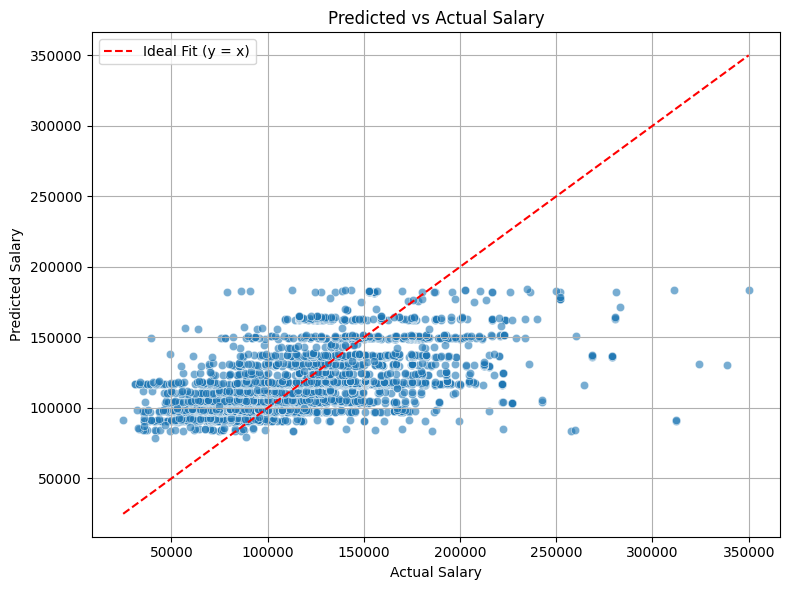

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pdf["SALARY"], y=pdf["prediction"], alpha=0.6)

# Ideal fit line: y = x
min_val = min(pdf["SALARY"].min(), pdf["prediction"].min())
max_val = max(pdf["SALARY"].max(), pdf["prediction"].max())

plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')

plt.title("Predicted vs Actual Salary")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
